In [241]:
import pandas as pd
import os
import seaborn as sb
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn as sk

# Load Data

In [242]:
client_df = pd.read_csv('.\\ficheiros_competicao_dev\\client.csv', sep=';', low_memory=False)

account_df = pd.read_csv('.\\ficheiros_competicao_dev\\account.csv', sep=';', low_memory=False)

trans_dev_df = pd.read_csv('.\\ficheiros_competicao_dev\\trans_dev.csv', sep=';', low_memory=False)

loan_dev_df = pd.read_csv('.\\ficheiros_competicao_dev\\loan_dev.csv', sep=';', low_memory=False)

card_dev_df = pd.read_csv('.\\ficheiros_competicao_dev\\card_dev.csv', sep=';', low_memory=False)

disp_df = pd.read_csv('.\\ficheiros_competicao_dev\\disp.csv', sep=';', low_memory=False)

district_df = pd.read_csv('.\\ficheiros_competicao_dev\\district.csv', sep=';', low_memory=False, na_values='?')

# Domain Analysis

## Business Understanding

### End User Requirements

The end user requires a system to determine which clients are and are not capable of paying of the loans they seek to make of the end user.

### Business Goals

In this problem the positive case is a client that cannot pay a loan. The business goal is to create a system to:
- Reduce the amount of loan attributions to clients who will default on the loan
- Mantain the amount of loan attributions to clients who can fulfill the loan

### Data Mining Goals

From the business goals we can determine that the goal of the model is to avoid granting a loan to a client who cannot pay it back, minimize false negatives so we must optimze for recall.

## Data Understanding

### Loans

In [243]:
len(loan_dev_df[loan_dev_df['status'] == 1]) / len(loan_dev_df) * 100

85.97560975609755

Around 86% of loans in the dataset have been payed off, so accuracy is not the best measure to optimize for.

<AxesSubplot:xlabel='status', ylabel='amount'>

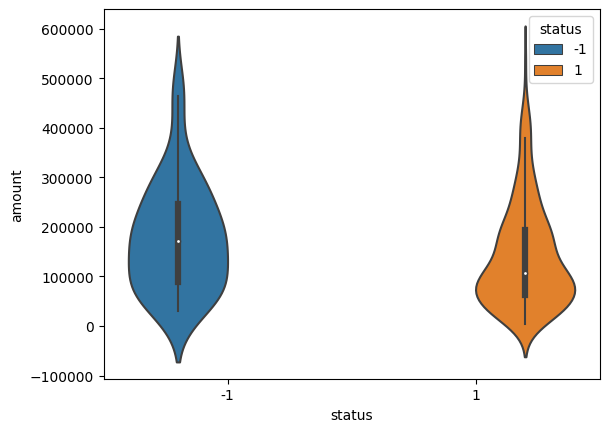

In [244]:
sb.violinplot(x='status', y='amount', data=loan_dev_df, hue='status')

We can see a larger amount of the loans over 100,000 are not payed off.

# Data Treatment

## Whitespace Removal

In [245]:
district_df.rename(columns=lambda x: x.strip(), inplace=True)

## Missing Values

### Acount

In [246]:
account_df.isnull().sum()

account_id     0
district_id    0
frequency      0
date           0
dtype: int64

No missing values on **account_df**

### Client

In [247]:
client_df.isnull().sum()

client_id       0
birth_number    0
district_id     0
dtype: int64

No missing values on **client_df**

### Loans

In [248]:
loan_dev_df.isnull().sum()

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64

No missing values on **loan_dev_df**

### Transactions

In [249]:
trans_dev_df.isnull().sum()

trans_id           0
account_id         0
date               0
type               0
operation      70761
amount             0
balance            0
k_symbol      185244
bank          299443
account       294456
dtype: int64

There are missing values on **trans_dev_df**

#### Operation

In [250]:
trans_dev_df['operation'].value_counts()

withdrawal in cash              165270
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

In [251]:
len(trans_dev_df[trans_dev_df['operation'].isnull()]) / len(trans_dev_df['operation']) * 100

17.838083113805663

There is a significant number of null values in the operations column. These will be replaced by 'N/A'.

In [252]:
trans_dev_df['operation'].fillna('N/A', inplace=True)

In [253]:
trans_dev_df['operation'].value_counts()

withdrawal in cash              165270
N/A                              70761
remittance to another bank       70737
credit in cash                   62202
collection from another bank     26505
credit card withdrawal            1210
Name: operation, dtype: int64

#### K Symbol

In [254]:
trans_dev_df['k_symbol'].value_counts()

interest credited                        70761
payment for statement                    58377
household                                42839
                                         19065
old-age pension                          13502
insurrance payment                        6592
sanction interest if negative balance      305
Name: k_symbol, dtype: int64

There are many empty string values. It is assumed these mean the transaction type wasn't registered and they will be treated the same as null values.

In [255]:
def remove_empty_values_k_symbol(k):
    if isinstance(k, float):
        return'N/A'
    elif isinstance(k, str) and k.strip() == '':
        return 'N/A'
    else:
        return k

trans_dev_df['k_symbol'] = trans_dev_df['k_symbol'].apply(remove_empty_values_k_symbol)

trans_dev_df['k_symbol'].value_counts()

N/A                                      204309
interest credited                         70761
payment for statement                     58377
household                                 42839
old-age pension                           13502
insurrance payment                         6592
sanction interest if negative balance       305
Name: k_symbol, dtype: int64

#### Bank

In [256]:
trans_dev_df['bank'].value_counts()

ST    8114
GH    7886
EF    7878
AB    7666
UV    7618
OP    7595
IJ    7536
YZ    7471
QR    7413
KL    7397
WX    7033
CD    7009
MN    6626
Name: bank, dtype: int64

There aren't any empty strings. Null values will be replaced by unknown.

In [257]:
trans_dev_df['bank'].fillna('Unknown', inplace=True)

In [258]:
trans_dev_df['bank'].value_counts()

Unknown    299443
ST           8114
GH           7886
EF           7878
AB           7666
UV           7618
OP           7595
IJ           7536
YZ           7471
QR           7413
KL           7397
WX           7033
CD           7009
MN           6626
Name: bank, dtype: int64

#### Account

In [259]:
trans_dev_df['account'].value_counts()

0.0           4987
15916598.0      48
62457513.0      48
6149286.0       48
42988401.0      48
              ... 
99218499.0       1
54261672.0       1
28306174.0       1
91523855.0       1
53761804.0       1
Name: account, Length: 4536, dtype: int64

There are many transactions to an account **0**. This will be treated as a transaction to an unknown account.

In [260]:
trans_dev_df['account'].fillna(0, inplace=True)

In [261]:
trans_dev_df['account'].value_counts()

0.0           299443
30300313.0        48
37906074.0        48
45134812.0        48
15916598.0        48
               ...  
99218499.0         1
54261672.0         1
28306174.0         1
91523855.0         1
53761804.0         1
Name: account, Length: 4536, dtype: int64

### Cards

In [262]:
card_dev_df.isnull().sum()

card_id    0
disp_id    0
type       0
issued     0
dtype: int64

There are no missing values in **card_dev_df**

### Disposition

In [263]:
disp_df.isnull().sum()

disp_id       0
client_id     0
account_id    0
type          0
dtype: int64

There are no missing values in **disp_df**

### District

In [264]:
district_df.isnull().sum()

code                                                0
name                                                0
region                                              0
no. of inhabitants                                  0
no. of municipalities with inhabitants < 499        0
no. of municipalities with inhabitants 500-1999     0
no. of municipalities with inhabitants 2000-9999    0
no. of municipalities with inhabitants >10000       0
no. of cities                                       0
ratio of urban inhabitants                          0
average salary                                      0
unemploymant rate '95                               1
unemploymant rate '96                               0
no. of enterpreneurs per 1000 inhabitants           0
no. of commited crimes '95                          1
no. of commited crimes '96                          0
dtype: int64

There are missing values in **district_df**

In [265]:
district_df[district_df['unemploymant rate \'95'].isnull()]

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,NaN,7.01,124,NaN,1358


Both null values com from the district of Jesenik.

We will replace the null values by finding the mean values for the region in 1995 and 1996 and inferring the 1995 values for Jesenik from the 1996 values.

In [266]:
unemp_rate_96_mean = district_df[district_df['region'] == 'north Moravia']['unemploymant rate \'96'].median()

unemp_rate_95_mean = district_df[district_df['region'] == 'north Moravia']['unemploymant rate \'95'].median()

unemp_rate_96_jes = district_df.iloc[68]['unemploymant rate \'96']

predicted_unemp_rate_95_jes = (unemp_rate_95_mean/unemp_rate_96_mean) * unemp_rate_96_jes

district_df['unemploymant rate \'95'].fillna(predicted_unemp_rate_95_jes, inplace=True)

crimes_96_mean = district_df[district_df['region'] == 'north Moravia']['no. of commited crimes \'96'].median()

crimes_95_mean = district_df[district_df['region'] == 'north Moravia']['no. of commited crimes \'95'].median()

crimes_96_jes = district_df.iloc[68]['no. of commited crimes \'96']

predicted_crimes_95_jes = (crimes_95_mean/crimes_96_mean) * crimes_96_jes

district_df['no. of commited crimes \'95'].fillna(predicted_crimes_95_jes, inplace=True)

## Date Functions

In [267]:
# Format birth number to date (DD-MM-YY) <- may need to change formatting for algorithms
def get_formatted_date(date_number):
    date_number_string = str(date_number)
    return date_number_string[4:6] + '/' + str(int(date_number_string[2:4]) % 50) + '/' + '19' + date_number_string[0:2]

# Get client sex from birth number (MM > 50 => sex == 'F')
def get_client_sex_from_birth_number(date_number):
    return 'F' if int(str(date_number)[2:4]) >= 51 else 'M'

def get_season_from_Date(date_string):
    date_string_str = str(date_string)
    day = int(date_string_str[8:10])
    month = int(date_string_str[5:7])
    year = int(date_string_str[0:4])

    winterStart = datetime.datetime(year, 12, 22)
    springStart = datetime.datetime(year, 3, 20)
    summerStart = datetime.datetime(year, 6, 21)
    autumnStart = datetime.datetime(year, 9, 22)

    if ((month <= 3 and day <= 20) or (month >= 12 and day > 22)):
        return "winter"
    elif (date_string < summerStart):
        return "spring"
    elif (date_string < autumnStart) : 
        return "summer"
    elif (date_string < winterStart) :
        return "autumn"

    return "FAILEDSEASON"

## Format dates and determine client sex

In [268]:
# Format client birthday and determine sex

client_df['birthday'] = pd.to_datetime(client_df['birth_number'].apply(get_formatted_date), infer_datetime_format=True)

client_df['sex'] = client_df['birth_number'].apply(get_client_sex_from_birth_number)

client_df = client_df.drop(columns=['birth_number'])

# Format other dates

account_df['acc_creation_date'] = pd.to_datetime(account_df['date'].apply(get_formatted_date), infer_datetime_format=True)

account_df = account_df.drop(columns=['date'])

trans_dev_df['trans_date'] = pd.to_datetime(trans_dev_df['date'].apply(get_formatted_date), infer_datetime_format=True)

trans_dev_df = trans_dev_df.drop(columns=['date'])

loan_dev_df['date'] = pd.to_datetime(loan_dev_df['date'].apply(get_formatted_date), infer_datetime_format=True)

card_dev_df['issued'] = pd.to_datetime(card_dev_df['issued'].apply(get_formatted_date), infer_datetime_format=True)

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '14/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '15/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '16/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '17/10/1993' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

c:\Users\andre\AppDa

# Join Data

Data must all be displayed in one dataset.

## Join Account and Disposition

In [269]:
joined_df = account_df.merge(disp_df, on='account_id', how='inner', suffixes=['', '_disp'])

joined_df.rename(columns={
    'type': 'account_type',
    'frequency': 'issuance_freq'
}, inplace=True)

# Determine if account is shared or not
owner_number_account = joined_df['account_id'].value_counts()

joined_df['shared'] = joined_df.apply(lambda row: 1 if owner_number_account[row['account_id']] > 1 else 0, axis=1)

# Drop rows with disponents so there are no duplicated account rows
joined_df.drop(joined_df[joined_df['account_type'] == 'DISPONENT'].index, inplace=True)

# Drop account_type and disp_id column
joined_df.drop(columns=['account_type'], inplace=True)

joined_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,client_id,shared
0,576,55,monthly issuance,1993-01-01,692,692,1
2,3818,74,monthly issuance,1993-01-01,4601,4601,1
4,704,55,monthly issuance,1993-01-01,844,844,1
6,2378,16,monthly issuance,1993-01-01,2873,2873,0
7,2632,24,monthly issuance,1993-02-01,3177,3177,0


## Join Clients

In [270]:
joined_df = joined_df.merge(client_df, on='client_id', how='left', suffixes=['', '_client'])

joined_df.drop(columns=['client_id'], inplace=True)

joined_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,shared,district_id_client,birthday,sex
0,576,55,monthly issuance,1993-01-01,692,1,74,1936-01-11,F
1,3818,74,monthly issuance,1993-01-01,4601,1,1,1935-04-02,M
2,704,55,monthly issuance,1993-01-01,844,1,22,1945-01-14,M
3,2378,16,monthly issuance,1993-01-01,2873,0,16,1975-03-24,F
4,2632,24,monthly issuance,1993-02-01,3177,0,24,1938-08-12,M


## Join District

There are currently two District ids in the dataset for each row. We are going to join on the client's district id since we surmise this information will be more relevant to wheter they pay off the loan or not than the district the account was registered on.

In [271]:
joined_df = joined_df.merge(district_df, left_on='district_id_client', right_on='code', how='inner', suffixes=['', '_district'])

joined_df.rename(columns={
    'code': 'district_code',
    'name': 'district_name'
}, inplace=True)

joined_df.drop(columns=['district_id', 'district_id_client'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,576,monthly issuance,1993-01-01,692,1,1936-01-11,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
1,2484,monthly issuance,1993-03-01,2999,0,1979-03-24,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
2,1338,monthly issuance,1993-11-01,1619,1,1942-01-27,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
3,1179,monthly issuance,1993-01-23,1419,1,1918-01-25,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
4,1649,monthly issuance,1993-01-26,1999,0,1982-02-10,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347


## Join Loan

In [272]:
joined_df = joined_df.merge(loan_dev_df, on='account_id', how='right', suffixes=['', '_loan'])

joined_df.rename(columns={
    'date': 'loan_date'
}, inplace=True)

# Add seasons
joined_df['season_on_loan'] = joined_df['loan_date'].apply(get_season_from_Date)

joined_df.head(100)

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan
0,1787,weekly issuance,1993-03-22,2166,0,1947-07-22,F,30,Sokolov,west Bohemia,...,100,2985.0,2804,5314,1993-05-07,96396,12,8033,-1,spring
1,1801,monthly issuance,1993-02-13,2181,0,1968-07-22,M,46,Nachod,east Bohemia,...,117,2854.0,2618,5316,1993-11-07,165960,36,4610,1,autumn
2,9188,monthly issuance,1993-08-02,11006,0,1936-06-02,M,45,Jicin,east Bohemia,...,132,2080.0,2122,6863,1993-07-28,127080,60,2118,1,summer
3,1843,monthly issuance,1993-01-30,2235,0,1940-04-20,F,14,Ceske Budejovice,south Bohemia,...,135,6604.0,6295,5325,1993-03-08,105804,36,2939,1,winter
4,11013,weekly issuance,1993-02-14,13231,0,1978-09-07,M,63,Vyskov,south Moravia,...,110,1562.0,1460,7240,1993-06-09,274740,60,4579,1,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8566,monthly issuance,1993-08-10,10258,0,1942-11-09,F,74,Ostrava - mesto,north Moravia,...,100,18782.0,18347,6738,1994-09-29,230220,36,6395,-1,autumn
96,7965,monthly issuance,1993-08-11,9536,1,1945-08-03,M,55,Brno - venkov,south Moravia,...,111,3659.0,3894,6624,1994-09-30,71460,12,5955,1,autumn
97,5952,monthly issuance,1993-07-09,7195,0,1962-09-11,M,50,Svitavy,east Bohemia,...,94,2123.0,2134,6216,1994-09-30,141240,24,5885,1,autumn
98,6040,monthly issuance,1993-04-22,7299,0,1938-09-16,M,1,Hl.m. Praha,Prague,...,167,85677.0,99107,6229,1994-02-10,11736,24,489,1,winter


## Determine account owner age on loan request

In [273]:
joined_df['age_on_loan_request'] = joined_df.apply(lambda row: (row['loan_date'] - row['birthday'])/np.timedelta64(1, 'Y'), axis=1)

joined_df.drop(columns=['birthday'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,no. of commited crimes '95,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,age_on_loan_request
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,2985.0,2804,5314,1993-05-07,96396,12,8033,-1,spring,45.794233
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,2854.0,2618,5316,1993-11-07,165960,36,4610,1,autumn,25.295523
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,2080.0,2122,6863,1993-07-28,127080,60,2118,1,summer,57.153809
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6604.0,6295,5325,1993-03-08,105804,36,2939,1,winter,52.882674
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,1562.0,1460,7240,1993-06-09,274740,60,4579,1,spring,14.754581


## Join Cards

There are a lot of clients without cards so simply joining the datasets would result in a large amount of null values. Instead we will record the card score attached to each account giving more weight to *classic* and *gold* cards. This is done beacause to have access to better credit cards the client must have a history of making and paying of loans in time.

In [274]:
card_disp_df = card_dev_df.merge(disp_df, on='disp_id', how='inner', suffixes=['_card', '_disp'])

cards_per_user_df = card_disp_df.groupby(['account_id', 'type_card']).size().unstack(fill_value=0)

joined_df = joined_df.merge(cards_per_user_df, on='account_id', how='left', suffixes=['', ''])

joined_df.fillna(0, inplace=True)

joined_df['card_score'] = (joined_df['junior'] + joined_df['classic'] * 3 + joined_df['gold'] * 10).astype(int)

joined_df.drop(columns=['junior', 'classic', 'gold'], inplace=True)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,age_on_loan_request,card_score
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,2804,5314,1993-05-07,96396,12,8033,-1,spring,45.794233,0
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,2618,5316,1993-11-07,165960,36,4610,1,autumn,25.295523,0
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,2122,6863,1993-07-28,127080,60,2118,1,summer,57.153809,0
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6295,5325,1993-03-08,105804,36,2939,1,winter,52.882674,0
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,1460,7240,1993-06-09,274740,60,4579,1,spring,14.754581,0


## Join Transactions

In [275]:
from dateutil.relativedelta import relativedelta

account_balance_df = trans_dev_df[['account_id', 'balance', 'trans_date']]

def find_balance_at_date(joined_df_row):
    # Get all balance information for account
    account_balances = account_balance_df[account_balance_df['account_id'] == joined_df_row['account_id']]

    if (account_balances.empty):
        joined_df_row['balance_at_loan'] = 0
        joined_df_row['balance_three_months_before'] = 0
        joined_df_row['balance_six_months_before'] = 0

        return joined_df_row[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']]
    
    # Get balance at loan date
    account_balances_at_loan_date = account_balances.copy()

    account_balances_at_loan_date['days_since_trans'] = account_balances_at_loan_date.apply(lambda row: (joined_df_row['loan_date'] - row['trans_date']), axis=1)

    account_balances_at_loan_date = account_balances_at_loan_date[account_balances_at_loan_date['days_since_trans'] >= pd.Timedelta(0)]

    account_balances_at_loan_date = account_balances_at_loan_date[account_balances_at_loan_date['days_since_trans'] == account_balances_at_loan_date['days_since_trans'].min()]


    # Get balance three months before loan date
    three_months_ago = joined_df_row['loan_date'] - relativedelta(months=3)

    account_balances_three_months_ago = account_balances.copy()

    account_balances_three_months_ago['days_since_trans'] = account_balances_three_months_ago.apply(lambda row: (three_months_ago - row['trans_date']), axis=1)

    account_balances_three_months_ago = account_balances_three_months_ago[account_balances_three_months_ago['days_since_trans'] >= pd.Timedelta(0)]

    account_balances_three_months_ago = account_balances_three_months_ago[account_balances_three_months_ago['days_since_trans'] == account_balances_three_months_ago['days_since_trans'].min()]

    # Get balance six months before loan date
    six_months_ago = joined_df_row['loan_date'] - relativedelta(months=6)

    account_balances_six_months_ago = account_balances.copy()

    account_balances_six_months_ago['days_since_trans'] = account_balances_six_months_ago.apply(lambda row: (six_months_ago - row['trans_date']), axis=1)

    account_balances_six_months_ago = account_balances_six_months_ago[account_balances_six_months_ago['days_since_trans'] >= pd.Timedelta(0)]

    account_balances_six_months_ago = account_balances_six_months_ago[account_balances_six_months_ago['days_since_trans'] == account_balances_six_months_ago['days_since_trans'].min()]


    joined_df_row['balance_at_loan'] = account_balances_at_loan_date.iloc[0]['balance'] if len(account_balances_at_loan_date.index) >= 1 else 0
    joined_df_row['balance_three_months_before'] = account_balances_three_months_ago.iloc[0]['balance'] if len(account_balances_three_months_ago.index) >= 1 else 0
    joined_df_row['balance_six_months_before'] = account_balances_six_months_ago.iloc[0]['balance'] if len(account_balances_six_months_ago.index) >= 1 else 0

    return joined_df_row[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']]

joined_df[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']] = joined_df.apply(find_balance_at_date, axis=1)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,amount,duration,payments,status,season_on_loan,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,96396,12,8033,-1,spring,45.794233,0,11000.0,0.0,0.0
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,165960,36,4610,1,autumn,25.295523,0,52208.9,52208.9,106447.2
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,127080,60,2118,1,summer,57.153809,0,20272.8,27619.5,0.0
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,105804,36,2939,1,winter,52.882674,0,40164.0,0.0,0.0
4,11013,weekly issuance,1993-02-14,13231,0,M,63,Vyskov,south Moravia,86513,...,274740,60,4579,1,spring,14.754581,0,59527.1,600.0,0.0


## Outliers

In [276]:
joined_df.describe()[['no. of commited crimes \'95', 'age_on_loan_request', 'duration', 'payments']]

,no. of commited crimes '95,age_on_loan_request,duration,payments
count,328.000000,328.000000,328.000000,328.000000
mean,14731.472419,36.242844,35.853659,4150.932927
std,27166.502446,12.559813,16.734752,2193.620989
min,818.000000,13.574543,12.000000,319.000000
25%,2157.000000,25.510449,24.000000,2368.750000
50%,3577.500000,35.536664,36.000000,3878.500000
75%,6949.000000,46.747709,48.000000,5907.750000
max,85677.000000,60.817128,60.000000,9689.000000


In [277]:
import plotly.express as px

fig = px.histogram(joined_df, x='no. of commited crimes \'95')
fig.show()

In [278]:
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

outliers = find_outliers_IQR(joined_df['no. of commited crimes \'95'])

print("number of outliers: " + str(len(outliers)))

print("max outlier value: " + str(outliers.max()))

print("min outlier value: " + str(outliers.min()))

number of outliers: 60
max outlier value: 85677.0
min outlier value: 18721.0


### Remove underage users

In [279]:
underage = joined_df.loc[joined_df['age_on_loan_request']<18]

joined_df.drop(underage.index, inplace=True)

joined_df.describe()[['age_on_loan_request']]


,age_on_loan_request
count,306.000000
mean,37.716602
std,11.685221
min,18.253626
25%,27.478319
50%,37.279342
75%,47.036558
max,60.817128


# Split into age brackets

In [280]:
import plotly.express as px

fig = px.histogram(joined_df, x='age_on_loan_request')
fig.show()

In [281]:
def get_age_bracket(age):
    if age >= 18 and age <= 24:
        return '18-24'
    elif age >= 25 and age <= 34:
        return '25-34'
    elif age>= 35 and age <= 44:
        return '35-44'
    elif age >= 45 and age <= 54:
        return '45-54'
    elif age >= 55 and age <= 64:
        return '55-64'
    elif age >= 65:
        return '65+'

joined_df['age_bracket'] = joined_df['age_on_loan_request'].apply(get_age_bracket)

joined_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,duration,payments,status,season_on_loan,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before,age_bracket
0,1787,weekly issuance,1993-03-22,2166,0,F,30,Sokolov,west Bohemia,94812,...,12,8033,-1,spring,45.794233,0,11000.0,0.0,0.0,45-54
1,1801,monthly issuance,1993-02-13,2181,0,M,46,Nachod,east Bohemia,112709,...,36,4610,1,autumn,25.295523,0,52208.9,52208.9,106447.2,25-34
2,9188,monthly issuance,1993-08-02,11006,0,M,45,Jicin,east Bohemia,77917,...,60,2118,1,summer,57.153809,0,20272.8,27619.5,0.0,55-64
3,1843,monthly issuance,1993-01-30,2235,0,F,14,Ceske Budejovice,south Bohemia,177686,...,36,2939,1,winter,52.882674,0,40164.0,0.0,0.0,45-54
6,11265,monthly issuance,1993-01-14,13537,0,M,15,Cesky Krumlov,south Bohemia,58796,...,12,4399,1,summer,20.578109,0,21029.0,24136.1,25279.8,18-24


## Set Correct Data Types

In [282]:
joined_df['shared'] = joined_df['shared'].astype('bool')

In [283]:
joined_df['status'] = joined_df['status'].apply(lambda x: 1 if x == -1 else 0)
joined_df['status'] = joined_df['status'].astype('bool')

In [284]:
joined_df.drop(columns=['district_name', 'account_id', 'disp_id', 'age_on_loan_request'], inplace=True)

### Remove Categorical Values

In [285]:
cat = ['sex', 'region', 'issuance_freq', 'season_on_loan', 'age_bracket']

joined_df[cat] = joined_df[cat].astype('category')

joined_df[cat] = joined_df[cat].apply(lambda x : x.cat.codes)

# Clustering - Data Description

In [286]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [287]:
print(joined_df.dtypes)

issuance_freq                                                 int8
acc_creation_date                                   datetime64[ns]
shared                                                        bool
sex                                                           int8
district_code                                                int64
region                                                        int8
no. of inhabitants                                           int64
no. of municipalities with inhabitants < 499                 int64
no. of municipalities with inhabitants 500-1999              int64
no. of municipalities with inhabitants 2000-9999             int64
no. of municipalities with inhabitants >10000                int64
no. of cities                                                int64
ratio of urban inhabitants                                 float64
average salary                                               int64
unemploymant rate '95                                      flo

## PCA

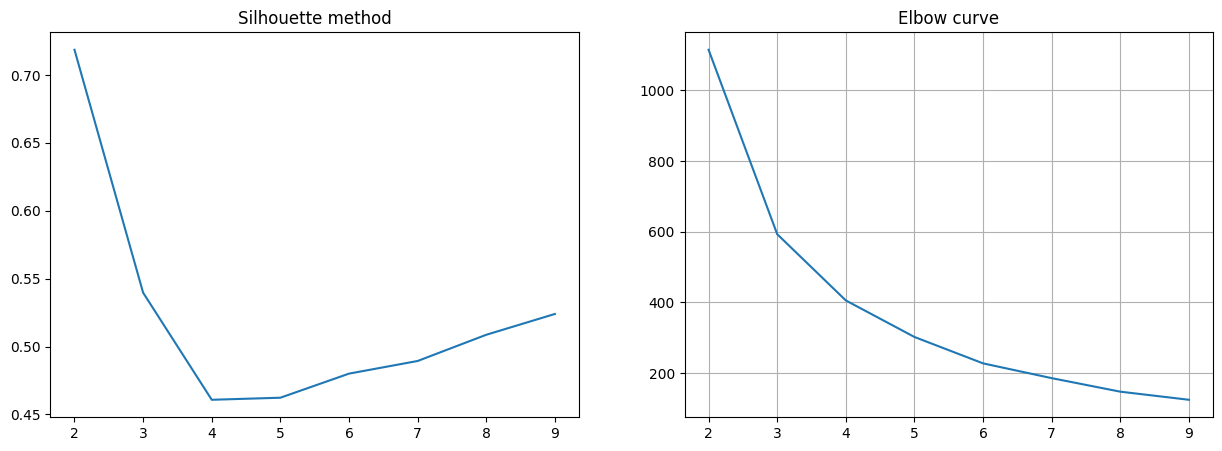

In [288]:
X = joined_df.drop(['status'], axis=1)
X.drop(columns=['acc_creation_date', 'loan_date'], inplace=True)
y = joined_df['status']

X = StandardScaler().fit_transform(X, y)
X = PCA(n_components=2, random_state=42).fit_transform(X)

wss = []
silhouette = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)
    silhouette.append(metrics.silhouette_score(X, kmeans.labels_))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(2, 10), silhouette)
ax[1].plot(range(2, 10), wss)

plt.grid(True)

ax[0].set_title('Silhouette method')
ax[1].set_title('Elbow curve')

plt.show()

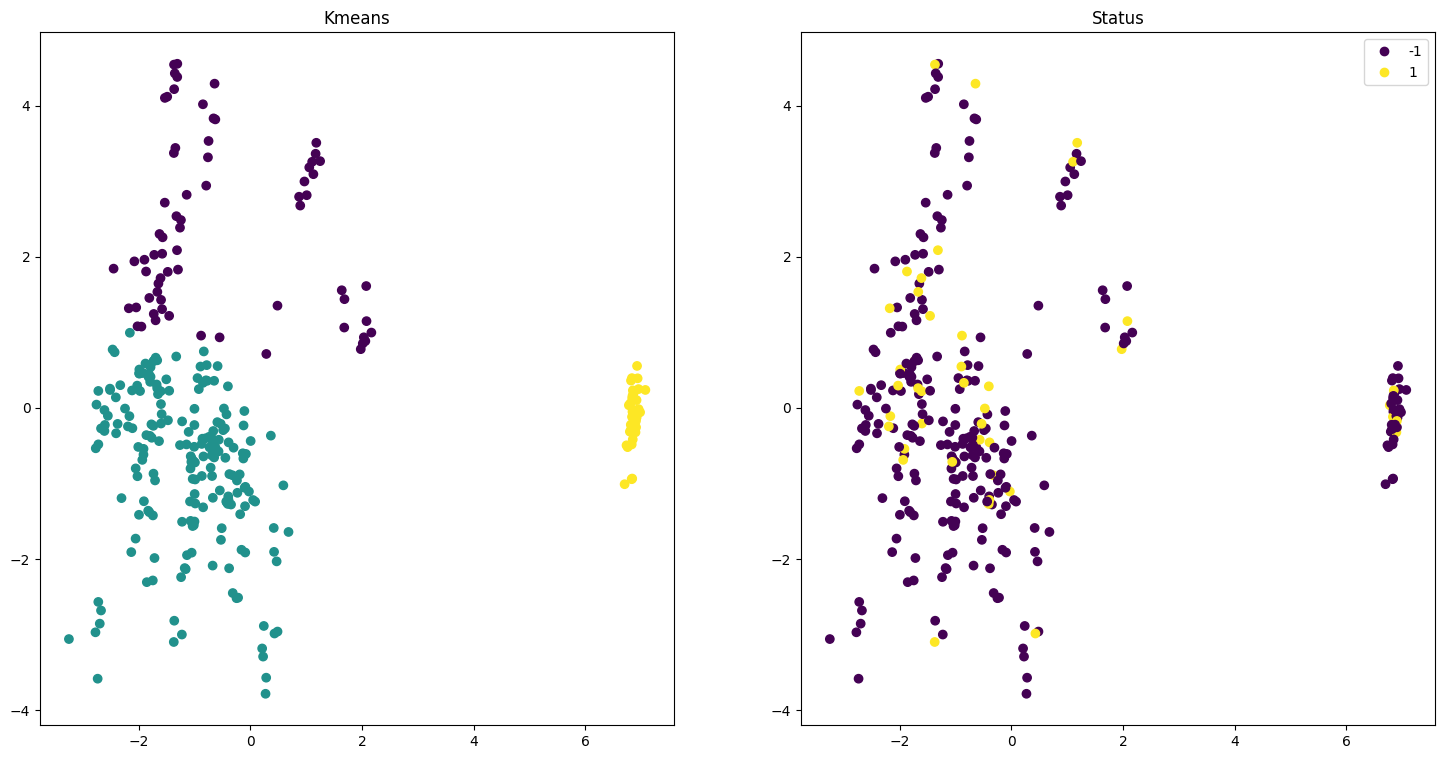

In [289]:
X = joined_df.drop(['status'], axis=1)
X.drop(columns=['acc_creation_date', 'loan_date'], inplace=True)
y = joined_df['status']

X = StandardScaler().fit_transform(X)
X = PCA(n_components=2, random_state=42).fit_transform(X)
db = KMeans(n_clusters=3, random_state=42).fit_predict(X)

# Plot result

fig, axs = plt.subplots(1, 2, figsize=(18, 9))

axs[0].scatter(X[:, 0], X[:, 1], c=db)

scatter = axs[1].scatter(X[:, 0], X[:, 1], c=y)

axs[0].set_title("Kmeans")
axs[1].set_title("Status")

axs[1].legend(handles=scatter.legend_elements()[0], labels=[-1, 1])

<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

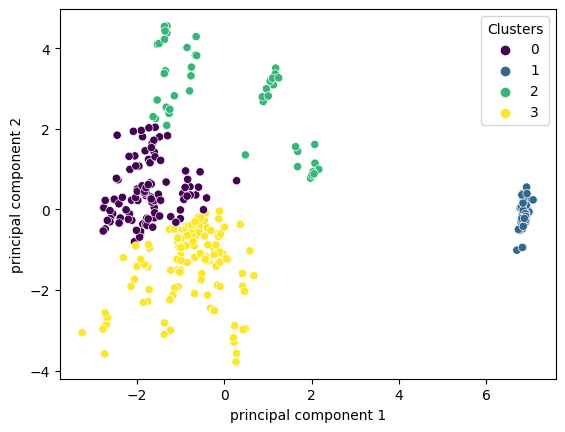

In [290]:
import sklearn.cluster as cluster
import seaborn as sns
kmeans = cluster.KMeans(n_clusters=4, random_state=42)
X=joined_df.drop(['status'],axis=1)
X.drop(columns=['acc_creation_date', 'loan_date'], inplace=True)
y = joined_df["status"]

X = StandardScaler().fit_transform(X)
X = PCA(n_components=2, random_state=42).fit_transform(X)

pca_df = pd.DataFrame(data = X, columns = ['principal component 1', 'principal component 2'])
kmeans = kmeans.fit(pca_df)

pca_df['Clusters'] = kmeans.labels_

sns.scatterplot(x="principal component 1", y="principal component 2",hue = 'Clusters',  data=pca_df,palette='viridis')

# Feature Selection

In [291]:
features = [
    'shared',
    'no. of municipalities with inhabitants < 499',
    'no. of municipalities with inhabitants 500-1999',
    'no. of municipalities with inhabitants 2000-9999',
    'no. of municipalities with inhabitants >10000', 
    'no. of cities',
    'ratio of urban inhabitants', 
    'average salary', 
    'unemploymant rate \'96', 
    'no. of enterpreneurs per 1000 inhabitants',
    'amount', 
    'duration', 
    'payments',
    'age_bracket',
    'card_score', 
    'balance_at_loan',
    'balance_three_months_before',
    'balance_six_months_before',
    'issuance_freq',
    'sex', 
    'district_code',
    'region',
    'season_on_loan'
    ]
    
target = 'status'

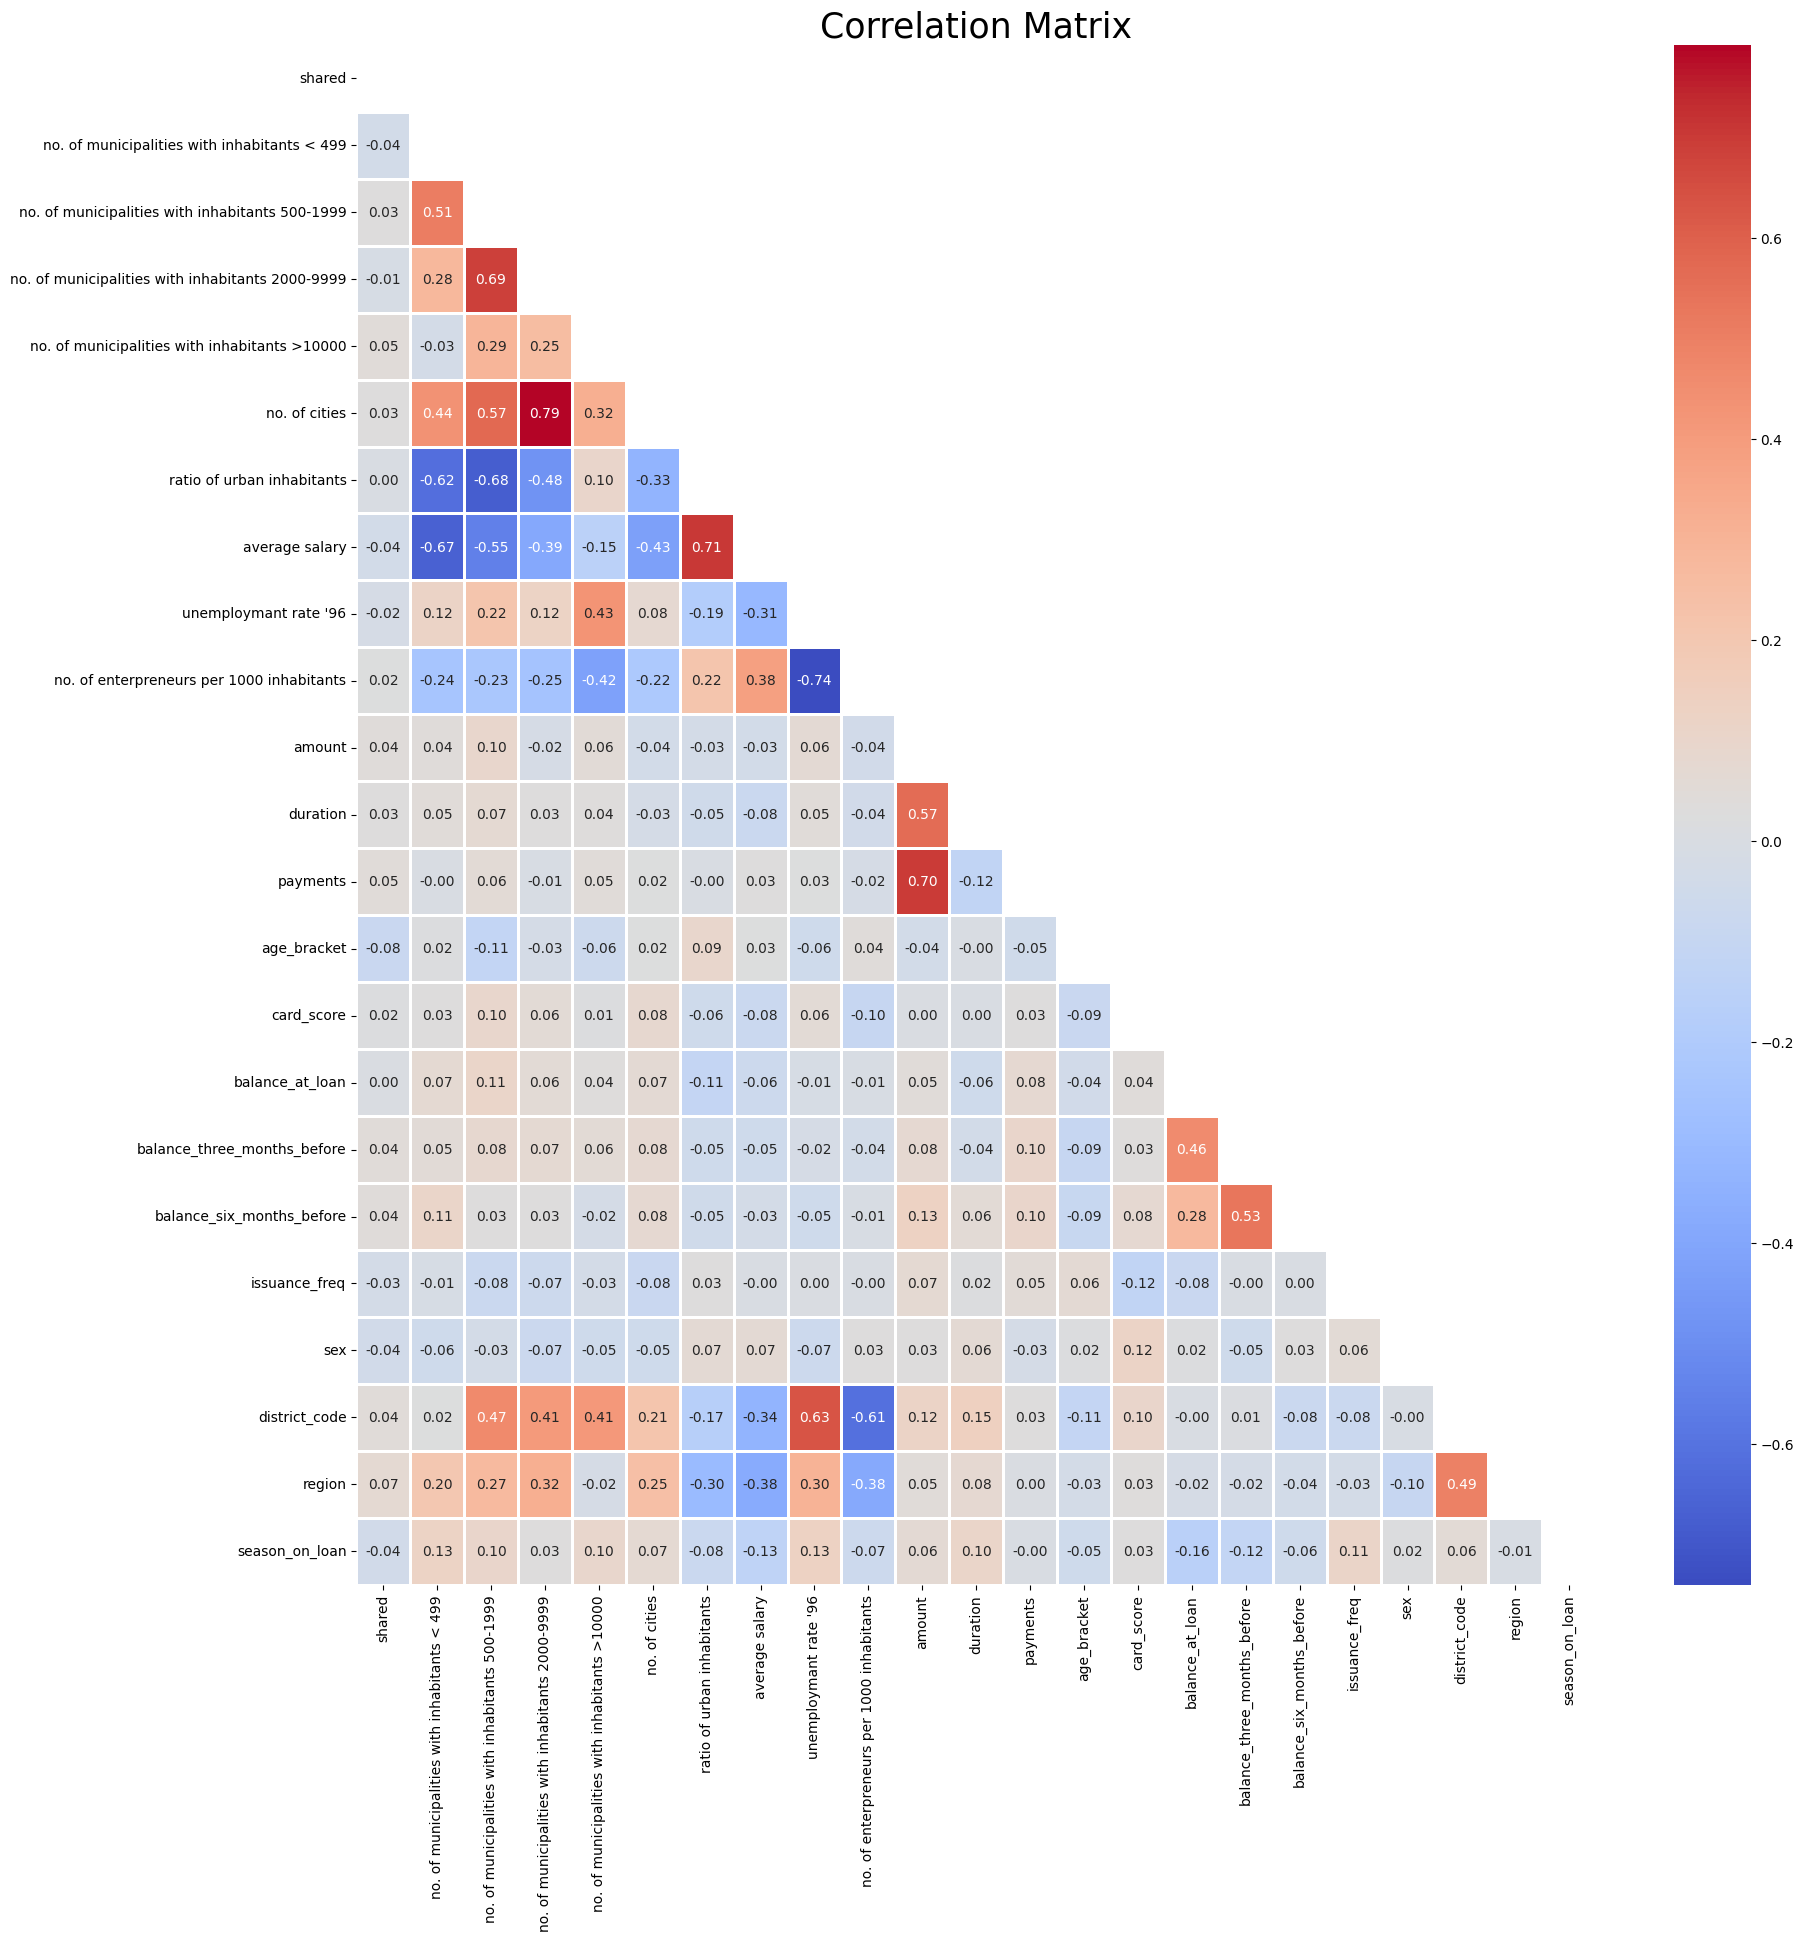

In [292]:
corr_matrix = joined_df[features].corr(method='spearman')

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20, 20))
plt.title('Correlation Matrix', fontsize=25)
_ = sb.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=2)

plt.show()

### VIF

We are going to test for VIF to check for multicolinearity between features

In [293]:
# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# compute the vif for all given features
def compute_vif(considered_features):
    
    X = joined_df[considered_features].copy()
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [294]:
numeric_features = [
    'no. of municipalities with inhabitants < 499',
    'no. of municipalities with inhabitants 500-1999',
    'no. of municipalities with inhabitants 2000-9999',
    'no. of municipalities with inhabitants >10000', 
    'no. of cities',
    'ratio of urban inhabitants', 
    'average salary', 
    'unemploymant rate \'96', 
    'no. of enterpreneurs per 1000 inhabitants',
    'amount', 
    'duration', 
    'payments',
    'card_score', 
    'balance_at_loan',
    'balance_three_months_before',
    'balance_six_months_before'
    ]

vif = compute_vif(numeric_features).sort_values(by='VIF', ascending=False)

vif

,Variable,VIF
9,amount,8.346492
6,average salary,6.505379
5,ratio of urban inhabitants,6.157302
11,payments,5.711442
2,no. of municipalities with inhabitants 2000-9999,4.786193
10,duration,4.664142
8,no. of enterpreneurs per 1000 inhabitants,4.531436
4,no. of cities,3.778315
1,no. of municipalities with inhabitants 500-1999,3.712732
7,unemploymant rate '96,2.980801


VIF threshhold at 5. removing amount and recalculating

In [295]:
numeric_features.remove('amount')

vif = compute_vif(numeric_features).sort_values(by='VIF', ascending=False)

vif

,Variable,VIF
6,average salary,6.501450
5,ratio of urban inhabitants,6.152632
2,no. of municipalities with inhabitants 2000-9999,4.785128
8,no. of enterpreneurs per 1000 inhabitants,4.518843
4,no. of cities,3.772202
1,no. of municipalities with inhabitants 500-1999,3.679911
7,unemploymant rate '96,2.964595
0,no. of municipalities with inhabitants < 499,2.560635
3,no. of municipalities with inhabitants >10000,1.810351
13,balance_three_months_before,1.537795


VIF on payments improved.

In [296]:
numeric_features.remove('average salary')

vif = compute_vif(numeric_features).sort_values(by='VIF', ascending=False)

vif

,Variable,VIF
2,no. of municipalities with inhabitants 2000-9999,4.258752
5,ratio of urban inhabitants,3.752402
1,no. of municipalities with inhabitants 500-1999,3.666042
7,no. of enterpreneurs per 1000 inhabitants,3.635548
6,unemploymant rate '96,2.949921
4,no. of cities,2.831061
0,no. of municipalities with inhabitants < 499,2.559091
3,no. of municipalities with inhabitants >10000,1.803647
12,balance_three_months_before,1.537725
13,balance_six_months_before,1.339153


All VIF values in threshold

In [297]:
features.remove('average salary')
features.remove('amount')

<AxesSubplot:xlabel='season_on_loan', ylabel='duration'>

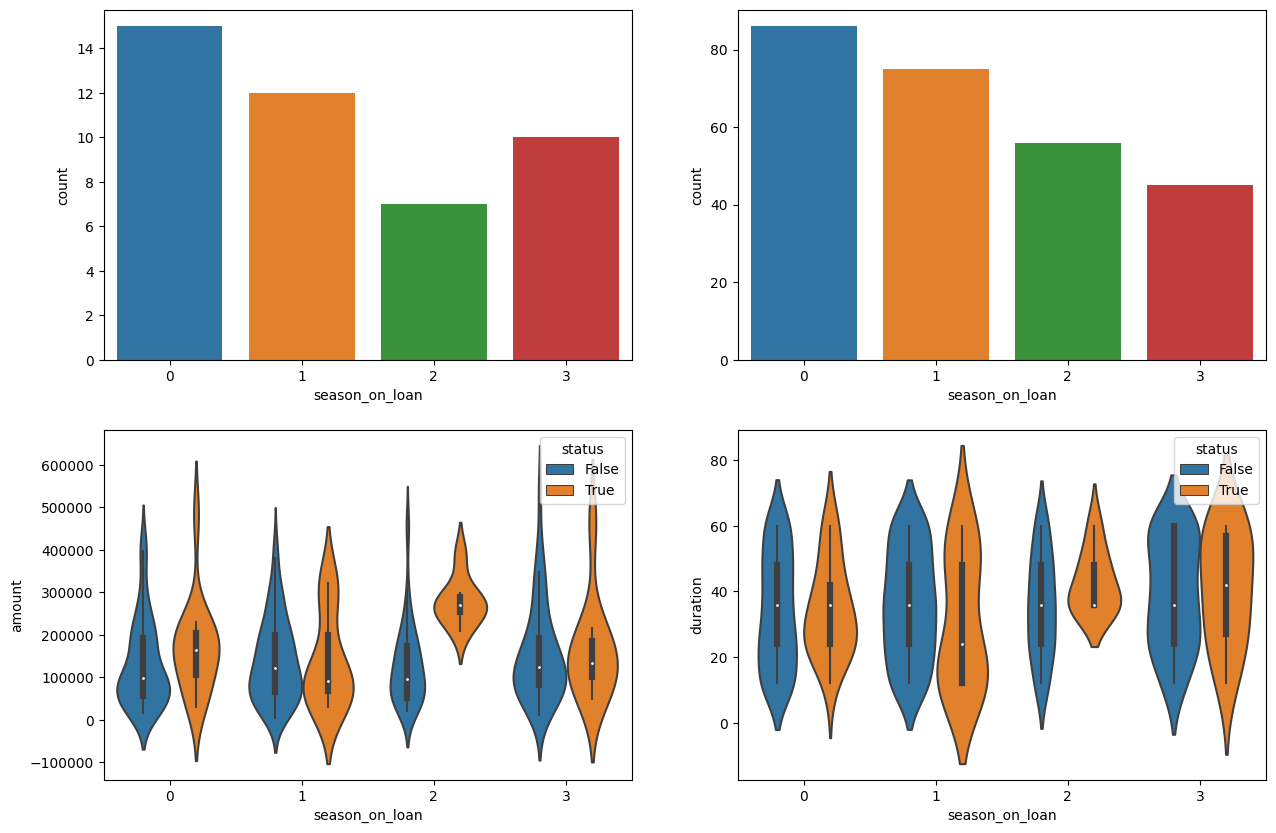

In [298]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 10)
sb.countplot(x="season_on_loan", data=joined_df[joined_df["status"] == 1], ax=ax[0][0])
sb.countplot(x="season_on_loan", data=joined_df[joined_df["status"] != 1], ax=ax[0][1])
sb.violinplot(x="season_on_loan", y="amount", data=joined_df, hue="status", ax=ax[1][0])
sb.violinplot(x="season_on_loan", y="duration", data=joined_df, hue="status", ax=ax[1][1])


Throughout the year the amount of accepted loans is descreasing. We can also notice in autumn the lower bound of loans are higher.

In [299]:
print(joined_df.columns)
# sb.lineplot(x="age_on_loan_request", y="balance_at_loan", data=joined_df)
# sb.displot(x="age_on_loan_request", data=joined_df, kde=True, hue="status")

Index(['issuance_freq', 'acc_creation_date', 'shared', 'sex', 'district_code',
       'region', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999',
       'no. of municipalities with inhabitants >10000', 'no. of cities',
       'ratio of urban inhabitants', 'average salary', 'unemploymant rate '95',
       'unemploymant rate '96', 'no. of enterpreneurs per 1000 inhabitants',
       'no. of commited crimes '95', 'no. of commited crimes '96', 'loan_id',
       'loan_date', 'amount', 'duration', 'payments', 'status',
       'season_on_loan', 'card_score', 'balance_at_loan',
       'balance_three_months_before', 'balance_six_months_before',
       'age_bracket'],
      dtype='object')


### ANOVA

In [300]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def do_anova(cols, k="all"):
    best_features = SelectKBest(score_func=f_classif, k=k)
    df_cut = joined_df[cols]
    fit = best_features.fit(df_cut, joined_df["status"])
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_cut.columns)

    # concat 2 dataFrame for better visualization
    feature_score = pd.concat([dfcolumns, dfscores], axis=1)
    feature_score.columns = ["Features", "Score"]
    ret = feature_score.sort_values(by="Score", ascending=False)
    return ret.head(k) if k != "all" else ret

In [301]:
do_anova(features)

,Features,Score
0,shared,15.936819
13,balance_at_loan,10.143509
10,payments,7.425428
15,balance_six_months_before,4.132036
14,balance_three_months_before,3.381195
1,no. of municipalities with inhabitants < 499,2.917119
5,no. of cities,2.661901
11,age_bracket,2.415465
19,region,1.329378
12,card_score,1.273617


In [302]:
selected_features = [
    'shared',
    'balance_at_loan',
    'payments',
    'balance_six_months_before',
    'balance_three_months_before',
    'season_on_loan',
    'age_bracket'
    ]

# Algorithms

In [303]:
print(joined_df.columns)

Index(['issuance_freq', 'acc_creation_date', 'shared', 'sex', 'district_code',
       'region', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999',
       'no. of municipalities with inhabitants >10000', 'no. of cities',
       'ratio of urban inhabitants', 'average salary', 'unemploymant rate '95',
       'unemploymant rate '96', 'no. of enterpreneurs per 1000 inhabitants',
       'no. of commited crimes '95', 'no. of commited crimes '96', 'loan_id',
       'loan_date', 'amount', 'duration', 'payments', 'status',
       'season_on_loan', 'card_score', 'balance_at_loan',
       'balance_three_months_before', 'balance_six_months_before',
       'age_bracket'],
      dtype='object')


In [304]:
print(joined_df.dtypes)

issuance_freq                                                 int8
acc_creation_date                                   datetime64[ns]
shared                                                        bool
sex                                                           int8
district_code                                                int64
region                                                        int8
no. of inhabitants                                           int64
no. of municipalities with inhabitants < 499                 int64
no. of municipalities with inhabitants 500-1999              int64
no. of municipalities with inhabitants 2000-9999             int64
no. of municipalities with inhabitants >10000                int64
no. of cities                                                int64
ratio of urban inhabitants                                 float64
average salary                                               int64
unemploymant rate '95                                      flo

In [305]:
X = joined_df[selected_features]
y = joined_df[target]

In [306]:
print(X.shape)

(306, 7)


In [307]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y) # 70% training and 30% test


### Normalization
Some of the algorithms we plan on using (KNN and SVM) require the data to be standardized. To do so, we used a StandardScaler from SciKit Learn's preprocessing library.

In [308]:
scaler = sk.preprocessing.StandardScaler()

scaler.fit(X_train)
x_train = scaler.fit_transform(X_train)
x_test = scaler.fit_transform(X_test)

## Descision Tree

In [309]:
# # Create Decision Tree classifer object
# clf = DecisionTreeClassifier(min_samples_leaf=15, max_depth=5)

# # Train Decision Tree Classifer
# clf = clf.fit(X_train,y_train)

# #Predict the response for test dataset
# y_pred = clf.predict(X_test)

In [310]:
# y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

In [311]:
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import PrecisionRecallDisplay

# print("Recall:",metrics.recall_score(y_test, y_pred))
# print("Precision:",metrics.precision_score(y_test, y_pred))

# display = PrecisionRecallDisplay.from_estimator(
#     clf, X_test, y_test, name="DecisionTree"
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")

In [312]:
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

# cm_display.plot()
# plt.show()

In [313]:
# from sklearn import tree

# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(clf, 
#                    feature_names=selected_features,  
#                    class_names=target,
#                    filled=True)


## SVC

In [314]:
# from sklearn.svm import SVC
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import PrecisionRecallDisplay

# # lsvc = SVC(C=0.01, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
# #  max_iter=-1, probability=True, random_state=1234, shrinking=True, tol=0.001, verbose=False)

# lsvc = SVC(verbose=0, C=0.01, kernel='poly')

# lsvc.fit(X_train, y_train)
# y_pred = lsvc.predict(X_test)

# score = lsvc.score(X_train, y_train)
# print(score)
# print("REcall: ", metrics.recall_score(y_test, y_pred))
# print("Precison: ", metrics.precision_score(y_test, y_pred))

# display = PrecisionRecallDisplay.from_estimator(
#     lsvc, X_test, y_test, name="SVC"
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")


In [315]:
# y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

In [316]:
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

# cm_display.plot()
# plt.show()

## Logistic Regression

In [317]:
# from sklearn.linear_model import LogisticRegression
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import PrecisionRecallDisplay


# logisticRegr = LogisticRegression(C=1.0, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
#  l1_ratio=None, max_iter=1000, multi_class='multinomial', n_jobs=None, penalty='l2', random_state=1234, solver='newton-cg',
#   tol=0.0001, verbose=0, warm_start=False)
# #multi_class : 'auto', 'ovr', 'multinomial'
# # solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
# logisticRegr.fit(X_train, y_train)
# y_pred = logisticRegr.predict(X_test)

# score = logisticRegr.score(X_train, y_train)
# print(score)
# print("REcall: ", metrics.recall_score(y_test, y_pred))
# print("Precison: ", metrics.precision_score(y_test, y_pred))
# print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

# display = PrecisionRecallDisplay.from_estimator(
#     logisticRegr, X_test, y_test, name="LogisticRegression"
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")

# NOT SURE HOW IT WORKS

# from sklearn.model_selection import cross_validate
# scoring = {"accuracy": "accuracy",
#            "precision": "precision",
#            "recall": "recall",
#            "f1": "f1",
#            "roc_auc": "roc_auc"}
# from sklearn.model_selection import RepeatedStratifiedKFold

# k = 5
# kr = 3
# kf = RepeatedStratifiedKFold(n_splits=k, n_repeats=kr, random_state=0)
# info = cross_validate(logisticRegr, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)
# pd.DataFrame(info).head()



In [318]:
# y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

In [319]:
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

# cm_display.plot()
# plt.show()

## LGBMC

In [320]:
# from lightgbm import LGBMClassifier
# from sklearn.metrics import PrecisionRecallDisplay
# from sklearn.metrics import PrecisionRecallDisplay

# lgbm = LGBMClassifier(task = 'train', objective='binary', num_classes = 1, random_state=0, learning_rate = 0.0005, num_iterations = 10000)
# # 'task': 'train',
# #     'boosting_type': 'gbdt',
# #     'objective': 'multiclass',
# #     'num_class':3,
# #     'metric': 'multi_logloss',
# #     'learning_rate': 0.002296,
# #     'max_depth': 7,
# #     'num_leaves': 17,
# #     'feature_fraction': 0.4,
# #     'bagging_fraction': 0.6,
# #     'bagging_freq': 17
# lgbm.fit(X_train, y_train)


# y_pred = lgbm.predict(X_test)   
# # lgbm.f1
# score = lgbm.score(X_train, y_train)
# print(score)
# print("REcall: ", metrics.recall_score(y_test, y_pred))
# print("Precison: ", metrics.precision_score(y_test, y_pred))


# display = PrecisionRecallDisplay.from_estimator(
#     lgbm, X_test, y_test, name="LGBM"
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")

In [321]:
# y_pred_proba = clf.predict_proba(X_test)
# print(y_pred_proba)

In [322]:
# confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

# cm_display.plot()
# plt.show()

# SMOTE

## Decision Tree

In [323]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [324]:
print(X_train_smote.shape)

(366, 7)


In [325]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train_smote,y_train_smote)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [326]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.31578947 0.68421053]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.27272727 0.72727273]
 [0.65909091 0.34090909]
 [0.96       0.04      ]
 [0.65909091 0.34090909]
 [0.27272727 0.72727273]
 [0.96       0.04      ]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.07692308 0.92307692]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [1.         0.        ]
 [0.09090909 0.90909091]
 [0.96       0.04      ]
 [0.63157895 0.36842105]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [0.31578947 0.68421053]
 [0.31578947 0.68421053]
 [0.63157895 0.36842105]
 [1.         0.        ]
 [0.96       0.04      ]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.07692308 0.92307692]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [0.27272727 0.72727273]
 [0.27272727 0.72727273]
 [0.27272727 0.72727273]
 [0.09090909 0.90909091]
 [0.96       0.04      ]
 [0.31578947 0.68421053]
 [0.76923077 0.23076923]
 [0.09090909 0.90909091]
 [0.63157895 0.36842105]


In [327]:
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precison: ", metrics.precision_score(y_test, y_pred))

Recall:  0.6153846153846154
Precison:  0.26666666666666666


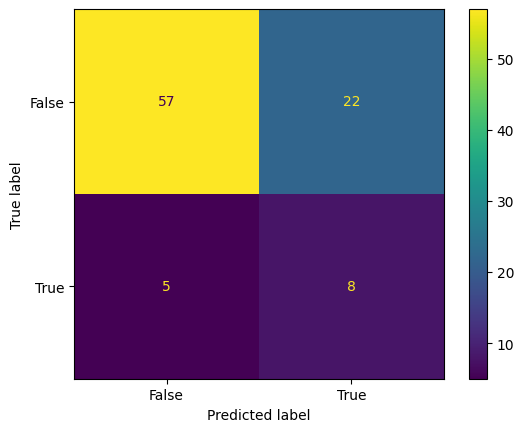

In [328]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

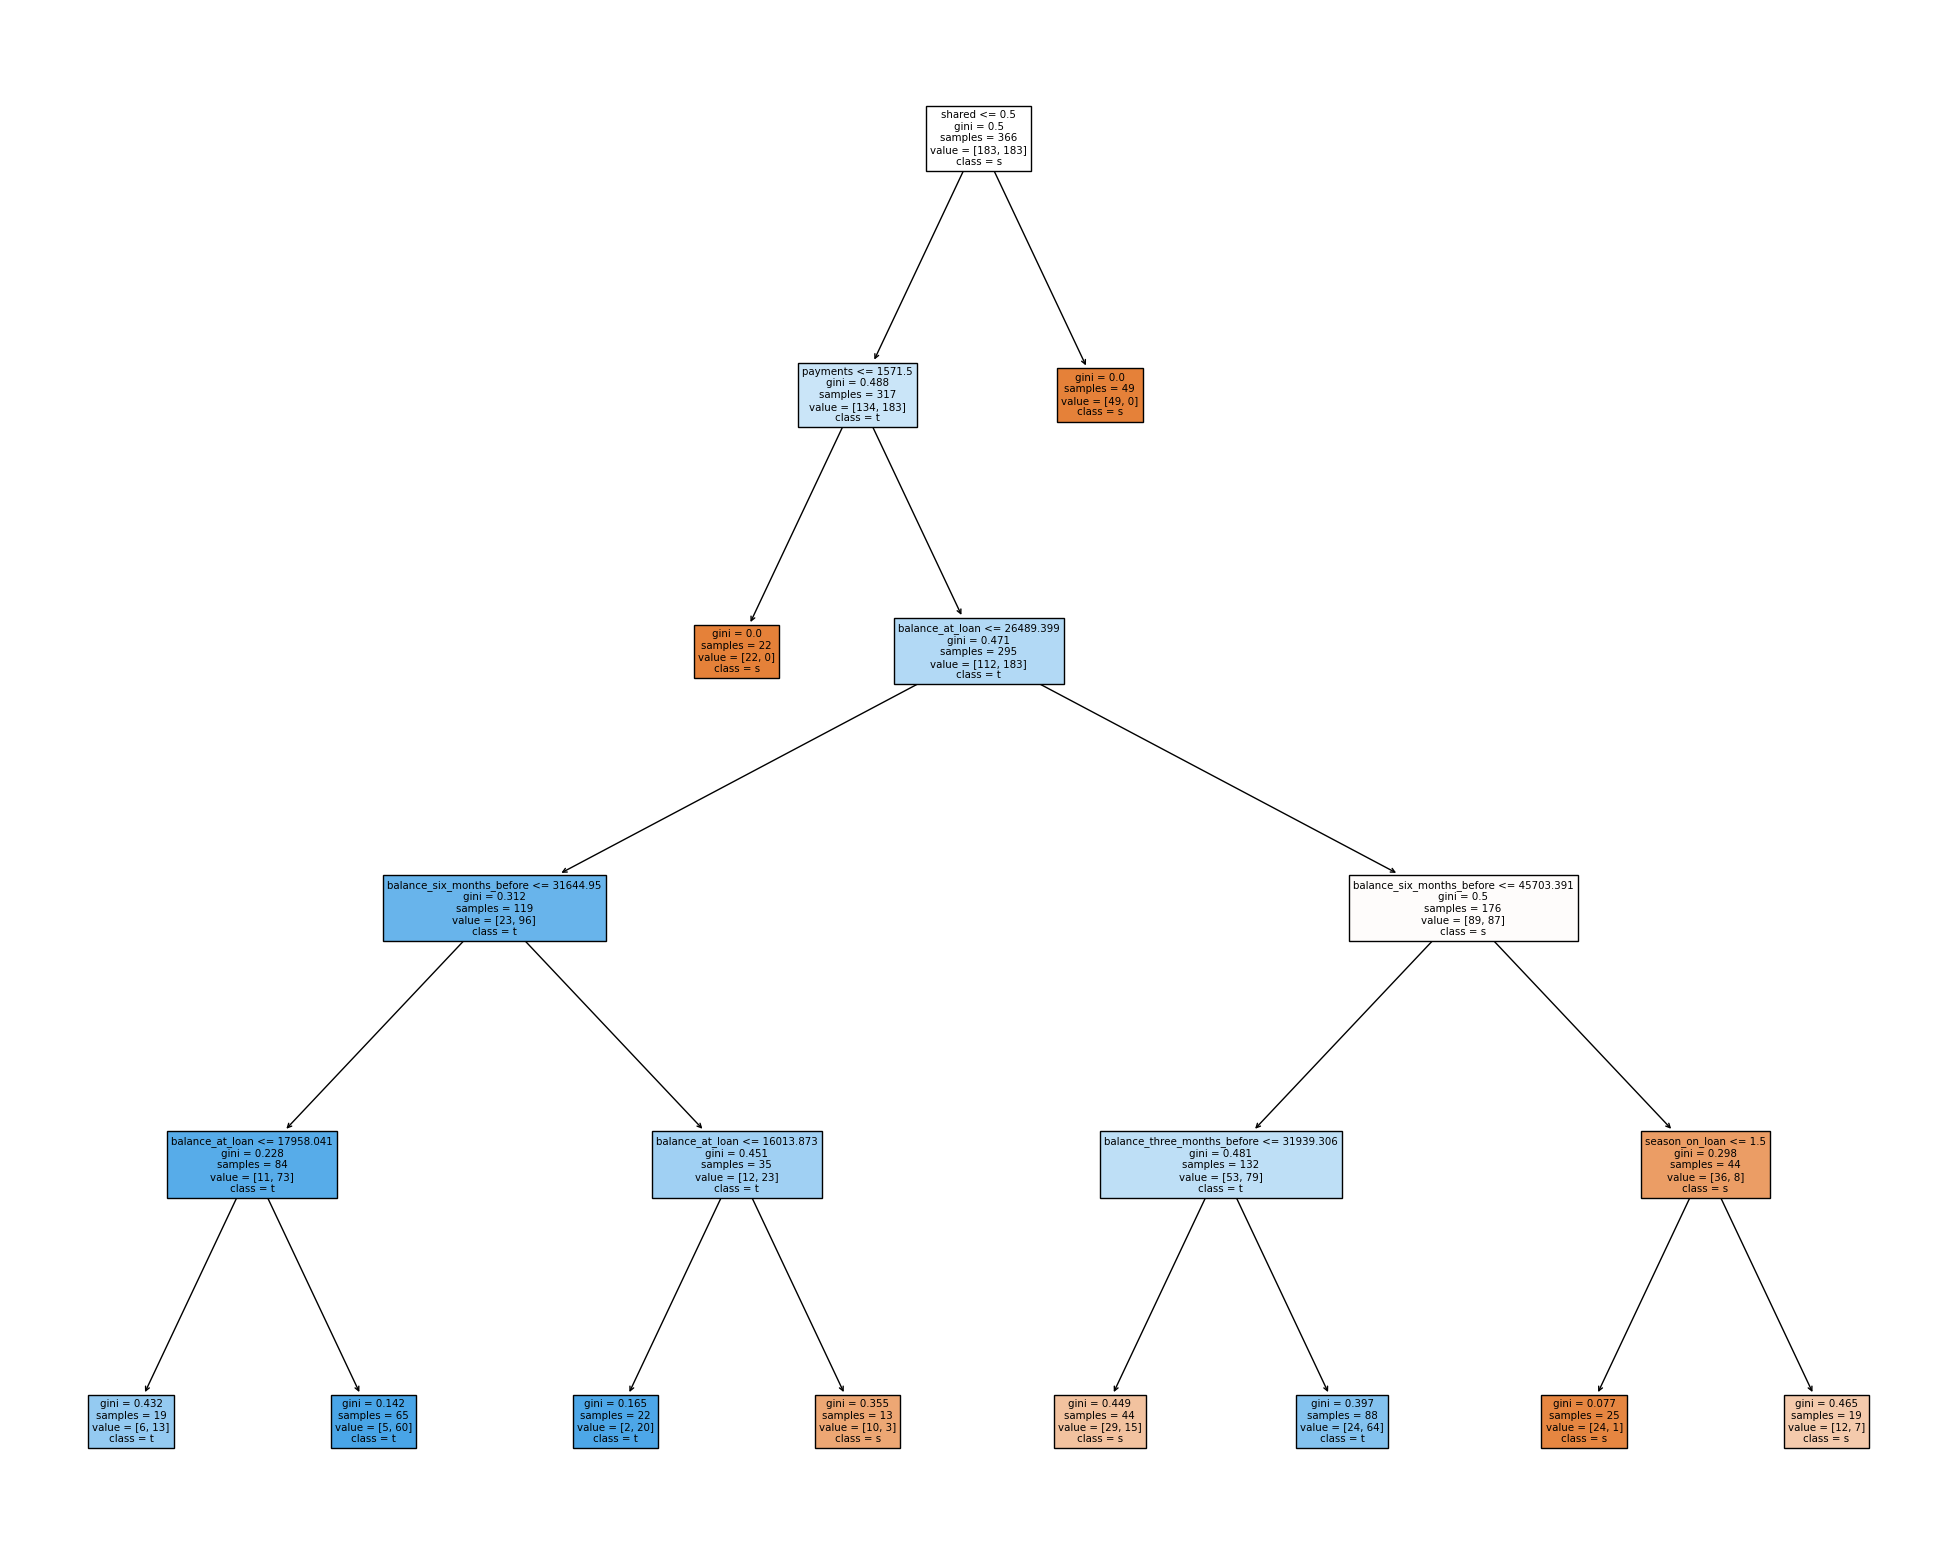

In [329]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=selected_features,  
                   class_names=target,
                   filled=True)

## SVC

0.6584699453551912
Recall:  0.6923076923076923
Precison:  0.25
AUROC:  0.675267770204479


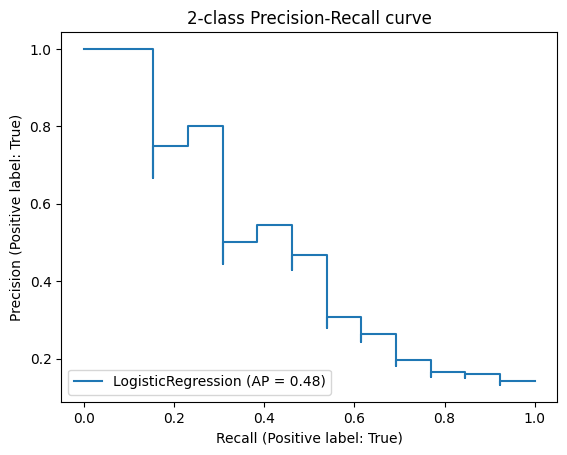

In [330]:
from sklearn.svm import SVC
from sklearn.metrics import PrecisionRecallDisplay

lsvc = SVC(verbose=0, C=0.5, kernel='rbf', probability=True)

lsvc.fit(X_train_smote, y_train_smote)
y_pred = lsvc.predict(X_test)

score = lsvc.score(X_train_smote, y_train_smote)
print(score)
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precison: ", metrics.precision_score(y_test, y_pred))
print("AUROC: ", metrics.roc_auc_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    lsvc, X_test, y_test, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [331]:
y_pred_proba = lsvc.predict_proba(X_test)
print(y_pred_proba)

[[0.43322399 0.56677601]
 [0.26887496 0.73112504]
 [0.51305602 0.48694398]
 [0.65684049 0.34315951]
 [0.68952902 0.31047098]
 [0.58317147 0.41682853]
 [0.79623046 0.20376954]
 [0.86047985 0.13952015]
 [0.34615994 0.65384006]
 [0.7589112  0.2410888 ]
 [0.74766965 0.25233035]
 [0.55489153 0.44510847]
 [0.32111829 0.67888171]
 [0.82425358 0.17574642]
 [0.51505188 0.48494812]
 [0.66642314 0.33357686]
 [0.36333548 0.63666452]
 [0.77961028 0.22038972]
 [0.6484694  0.3515306 ]
 [0.64869918 0.35130082]
 [0.78798915 0.21201085]
 [0.28627532 0.71372468]
 [0.25826936 0.74173064]
 [0.80070759 0.19929241]
 [0.61794791 0.38205209]
 [0.75598403 0.24401597]
 [0.39994589 0.60005411]
 [0.62278832 0.37721168]
 [0.3580898  0.6419102 ]
 [0.46979146 0.53020854]
 [0.39419    0.60581   ]
 [0.77333343 0.22666657]
 [0.52040017 0.47959983]
 [0.75096216 0.24903784]
 [0.30982947 0.69017053]
 [0.82198546 0.17801454]
 [0.29249914 0.70750086]
 [0.42228254 0.57771746]
 [0.33112373 0.66887627]
 [0.75488994 0.24511006]


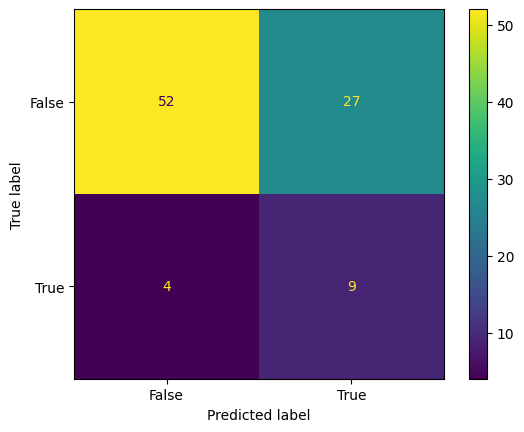

In [332]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## Logistic Regession

0.6912568306010929
Recall:  0.6923076923076923
Precison:  0.28125
Accuracy:  0.7065217391304348


c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning:

The line search algorithm did not converge

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning:

The line search algorithm did not converge

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_linesearch.py:415: LineSearchWarning:

Rounding errors prevent the line search from converging

c:\Users\andre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning:

Line Search failed



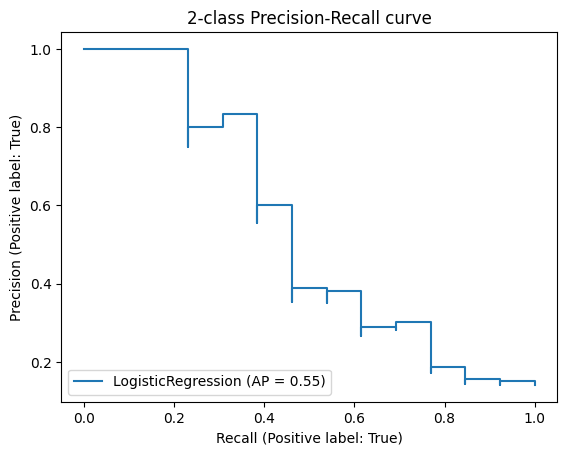

In [333]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import PrecisionRecallDisplay


# logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr = LogisticRegression(C=0.01, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1,
 l1_ratio=None, max_iter=1000, multi_class='multinomial', n_jobs=None, penalty='l2', random_state=1234, solver='newton-cg',
  tol=0.0001, verbose=0, warm_start=False)

logisticRegr.fit(X_train_smote, y_train_smote)
y_pred = logisticRegr.predict(X_test)

score = logisticRegr.score(X_train_smote, y_train_smote)
print(score)
print("Recall: ", metrics.recall_score(y_test, y_pred))
print("Precison: ", metrics.precision_score(y_test, y_pred))
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

display = PrecisionRecallDisplay.from_estimator(
    logisticRegr, X_test, y_test, name="LogisticRegression"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [334]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.31578947 0.68421053]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.27272727 0.72727273]
 [0.65909091 0.34090909]
 [0.96       0.04      ]
 [0.65909091 0.34090909]
 [0.27272727 0.72727273]
 [0.96       0.04      ]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.07692308 0.92307692]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [1.         0.        ]
 [0.09090909 0.90909091]
 [0.96       0.04      ]
 [0.63157895 0.36842105]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [0.31578947 0.68421053]
 [0.31578947 0.68421053]
 [0.63157895 0.36842105]
 [1.         0.        ]
 [0.96       0.04      ]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.07692308 0.92307692]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [0.27272727 0.72727273]
 [0.27272727 0.72727273]
 [0.27272727 0.72727273]
 [0.09090909 0.90909091]
 [0.96       0.04      ]
 [0.31578947 0.68421053]
 [0.76923077 0.23076923]
 [0.09090909 0.90909091]
 [0.63157895 0.36842105]


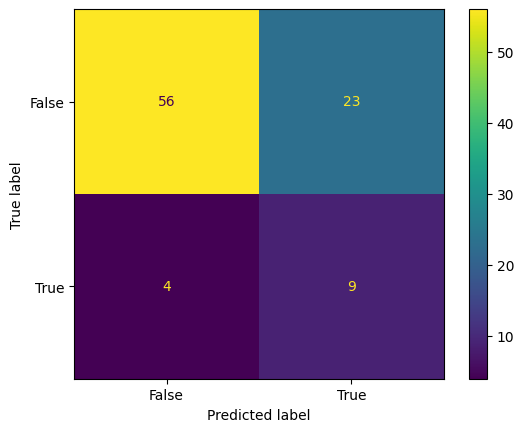

In [335]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## LGBMC

1.0
REcall:  0.5384615384615384
Precison:  0.3888888888888889


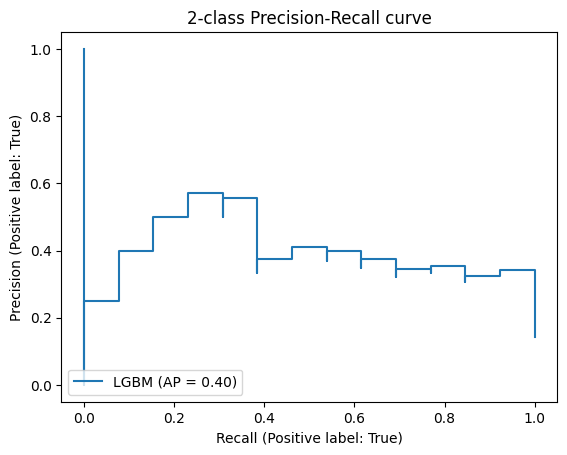

In [336]:
from lightgbm import LGBMClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import PrecisionRecallDisplay

lgbm = LGBMClassifier(objective='binary', random_state=0)
lgbm.fit(X_train_smote, y_train_smote)


y_pred = lgbm.predict(X_test)   
# lgbm.f1
score = lgbm.score(X_train_smote, y_train_smote)
print(score)
print("REcall: ", metrics.recall_score(y_test, y_pred))
print("Precison: ", metrics.precision_score(y_test, y_pred))


display = PrecisionRecallDisplay.from_estimator(
    lgbm, X_test, y_test, name="LGBM"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [337]:
y_pred_proba = clf.predict_proba(X_test)
print(y_pred_proba)

[[1.         0.        ]
 [0.31578947 0.68421053]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.27272727 0.72727273]
 [0.65909091 0.34090909]
 [0.96       0.04      ]
 [0.65909091 0.34090909]
 [0.27272727 0.72727273]
 [0.96       0.04      ]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.07692308 0.92307692]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [1.         0.        ]
 [0.09090909 0.90909091]
 [0.96       0.04      ]
 [0.63157895 0.36842105]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [0.31578947 0.68421053]
 [0.31578947 0.68421053]
 [0.63157895 0.36842105]
 [1.         0.        ]
 [0.96       0.04      ]
 [0.27272727 0.72727273]
 [1.         0.        ]
 [0.07692308 0.92307692]
 [0.65909091 0.34090909]
 [1.         0.        ]
 [0.27272727 0.72727273]
 [0.27272727 0.72727273]
 [0.27272727 0.72727273]
 [0.09090909 0.90909091]
 [0.96       0.04      ]
 [0.31578947 0.68421053]
 [0.76923077 0.23076923]
 [0.09090909 0.90909091]
 [0.63157895 0.36842105]


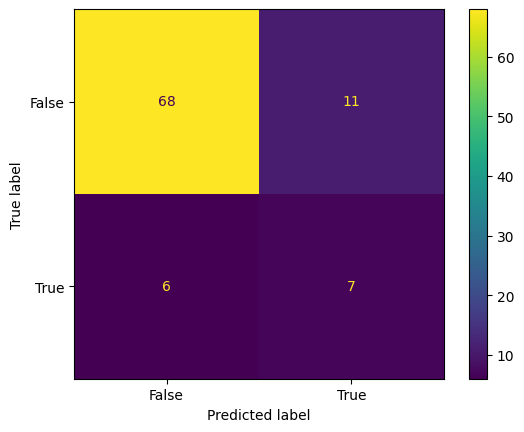

In [338]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

## KNN

In [339]:
knn = sk.neighbors.KNeighborsClassifier(
    n_neighbors=50,
    weights='distance',
    algorithm='ball_tree',
    leaf_size=1,
    n_jobs=-1
    )

knn.fit(X_train_smote, y_train_smote)
y_pred = knn.predict(X_test)
print(sk.metrics.accuracy_score(y_test, y_pred))
print("Recall: ",sk.metrics.recall_score(y_test, y_pred))
print("Precision: ", sk.metrics.precision_score(y_test, y_pred))
print("AUROC: ", sk.metrics.roc_auc_score(y_test, y_pred))

0.7391304347826086
Recall:  0.6153846153846154
Precision:  0.2962962962962963
AUROC:  0.6874391431353457


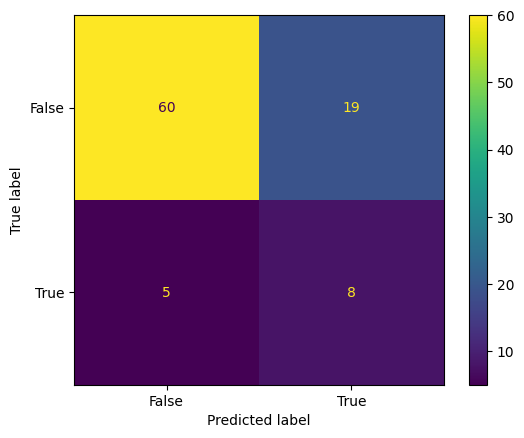

In [340]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 

cm_display.plot()
plt.show()

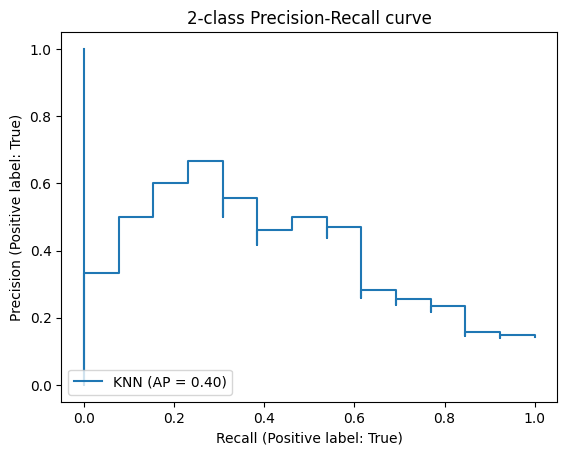

In [341]:
display = PrecisionRecallDisplay.from_estimator(
    knn, X_test, y_test, name="KNN"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [342]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150, criterion='gini', n_jobs=-1, max_features='sqrt', max_depth=150)

rf.fit(X_train_smote, y_train_smote)

y_pred = rf.predict(X_test)

print("Recall: ", metrics.recall_score(y_test, y_pred))

Recall:  0.5384615384615384


# Competition

## Prepare competition data

### Load

In [343]:
trans_comp_df = pd.read_csv('.\\ficheiros_competicao_dev\\trans_comp.csv', sep=';', low_memory=False)

loan_comp_df = pd.read_csv('.\\ficheiros_competicao_dev\\loan_comp.csv', sep=';', low_memory=False)

card_comp_df = pd.read_csv('.\\ficheiros_competicao_dev\\card_comp.csv', sep=';', low_memory=False)

### Treat data

In [344]:
trans_comp_df['operation'].fillna('N/A', inplace=True)
trans_comp_df['k_symbol'] = trans_comp_df['k_symbol'].apply(remove_empty_values_k_symbol)
trans_comp_df['bank'].fillna('Unknown', inplace=True)
trans_comp_df['account'].fillna(0, inplace=True)

In [345]:
trans_comp_df['trans_date'] = pd.to_datetime(trans_comp_df['date'].apply(get_formatted_date), infer_datetime_format=True)

trans_comp_df = trans_comp_df.drop(columns=['date'])

loan_comp_df['date'] = pd.to_datetime(loan_comp_df['date'].apply(get_formatted_date), infer_datetime_format=True)

card_comp_df['issued'] = pd.to_datetime(card_comp_df['issued'].apply(get_formatted_date), infer_datetime_format=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_24752\2241467942.py:5: UserWarning:

Parsing '14/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24752\2241467942.py:5: UserWarning:

Parsing '17/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24752\2241467942.py:5: UserWarning:

Parsing '19/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24752\2241467942.py:5: UserWarning:

Parsing '20/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\andre\AppData\Local\Temp\ipykernel_24752\2241467942.py:5: UserWarning:

Parsing '21/10/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent 

### Join Data

#### Account and Disposition

In [346]:
comp_df = account_df.merge(disp_df, on='account_id', how='inner', suffixes=['', '_disp'])

comp_df.rename(columns={
    'type': 'account_type',
    'frequency': 'issuance_freq'
}, inplace=True)

# Determine if account is shared or not
owner_number_account = comp_df['account_id'].value_counts()

comp_df['shared'] = comp_df.apply(lambda row: 1 if owner_number_account[row['account_id']] > 1 else 0, axis=1)

# Drop rows with disponents so there are no duplicated account rows
comp_df.drop(comp_df[comp_df['account_type'] == 'DISPONENT'].index, inplace=True)

# Drop account_type and disp_id column
comp_df.drop(columns=['account_type'], inplace=True)

comp_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,client_id,shared
0,576,55,monthly issuance,1993-01-01,692,692,1
2,3818,74,monthly issuance,1993-01-01,4601,4601,1
4,704,55,monthly issuance,1993-01-01,844,844,1
6,2378,16,monthly issuance,1993-01-01,2873,2873,0
7,2632,24,monthly issuance,1993-02-01,3177,3177,0


##### Competition and Clients

In [347]:
comp_df = comp_df.merge(client_df, on='client_id', how='left', suffixes=['', '_client'])

comp_df.drop(columns=['client_id'], inplace=True)

comp_df.head()

,account_id,district_id,issuance_freq,acc_creation_date,disp_id,shared,district_id_client,birthday,sex
0,576,55,monthly issuance,1993-01-01,692,1,74,1936-01-11,F
1,3818,74,monthly issuance,1993-01-01,4601,1,1,1935-04-02,M
2,704,55,monthly issuance,1993-01-01,844,1,22,1945-01-14,M
3,2378,16,monthly issuance,1993-01-01,2873,0,16,1975-03-24,F
4,2632,24,monthly issuance,1993-02-01,3177,0,24,1938-08-12,M


#### Competition and District

In [348]:
comp_df = comp_df.merge(district_df, left_on='district_id_client', right_on='code', how='inner', suffixes=['', '_district'])

comp_df.rename(columns={
    'code': 'district_code',
    'name': 'district_name'
}, inplace=True)

comp_df.drop(columns=['district_id', 'district_id_client'], inplace=True)

comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,576,monthly issuance,1993-01-01,692,1,1936-01-11,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
1,2484,monthly issuance,1993-03-01,2999,0,1979-03-24,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
2,1338,monthly issuance,1993-11-01,1619,1,1942-01-27,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
3,1179,monthly issuance,1993-01-23,1419,1,1918-01-25,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347
4,1649,monthly issuance,1993-01-26,1999,0,1982-02-10,F,74,Ostrava - mesto,north Moravia,...,0,1,1,100.0,10673,4.75,5.44,100,18782.0,18347


#### Competition and Loan

In [349]:
comp_df = comp_df.merge(loan_comp_df, on='account_id', how='right', suffixes=['', '_loan'])

comp_df.rename(columns={
    'date': 'loan_date'
}, inplace=True)

# Add seasons
comp_df['season_on_loan'] = comp_df['loan_date'].apply(get_season_from_Date)

comp_df.head(100)

,account_id,issuance_freq,acc_creation_date,disp_id,shared,birthday,sex,district_code,district_name,region,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan
0,4473,monthly issuance,1995-09-10,5395,0,1962-06-01,M,45,Jicin,east Bohemia,...,132,2080.0,2122,5895,1997-03-01,93960,60,1566,NaN,winter
1,10365,monthly issuance,1995-02-09,12448,0,1949-01-21,F,22,Domazlice,west Bohemia,...,100,1089.0,1117,7122,1997-04-01,260640,36,7240,NaN,spring
2,5724,issuance after transaction,1995-04-19,6922,0,1939-04-27,F,14,Ceske Budejovice,south Bohemia,...,135,6604.0,6295,6173,1997-08-01,232560,48,4845,NaN,summer
3,5591,monthly issuance,1996-03-16,6749,1,1943-09-29,F,9,Nymburk,central Bohemia,...,149,2987.0,2487,6142,1997-01-21,221880,60,3698,NaN,spring
4,2018,monthly issuance,1995-04-06,2451,0,1939-12-06,M,42,Havlickuv Brod,east Bohemia,...,87,1658.0,1668,5358,1997-01-21,38520,12,3210,NaN,spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,442,monthly issuance,1997-03-30,533,0,1941-05-19,F,54,Brno - mesto,south Moravia,...,140,18721.0,18696,5063,1997-10-07,357840,48,7455,NaN,autumn
96,319,weekly issuance,1995-10-17,389,0,1974-06-30,F,47,Pardubice,east Bohemia,...,111,6079.0,5410,5041,1997-11-07,369000,60,6150,NaN,autumn
97,525,monthly issuance,1996-03-20,631,0,1956-03-22,F,70,Karvina,north Moravia,...,81,9878.0,10108,5086,1997-07-16,210384,48,4383,NaN,summer
98,9513,monthly issuance,1996-12-05,11405,1,1951-04-11,F,59,Kromeriz,south Moravia,...,106,2595.0,2305,6942,1997-07-16,18324,12,1527,NaN,summer


In [350]:
comp_df['age_on_loan_request'] = comp_df.apply(lambda row: (row['loan_date'] - row['birthday'])/np.timedelta64(1, 'Y'), axis=1)

comp_df.drop(columns=['birthday'], inplace=True)

comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,no. of commited crimes '95,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,age_on_loan_request
0,4473,monthly issuance,1995-09-10,5395,0,M,45,Jicin,east Bohemia,77917,...,2080.0,2122,5895,1997-03-01,93960,60,1566,NaN,winter,34.749516
1,10365,monthly issuance,1995-02-09,12448,0,F,22,Domazlice,west Bohemia,58400,...,1089.0,1117,7122,1997-04-01,260640,36,7240,NaN,spring,48.192639
2,5724,issuance after transaction,1995-04-19,6922,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6604.0,6295,6173,1997-08-01,232560,48,4845,NaN,summer,58.265399
3,5591,monthly issuance,1996-03-16,6749,1,F,9,Nymburk,central Bohemia,81344,...,2987.0,2487,6142,1997-01-21,221880,60,3698,NaN,spring,53.315263
4,2018,monthly issuance,1995-04-06,2451,0,M,42,Havlickuv Brod,east Bohemia,95907,...,1658.0,1668,5358,1997-01-21,38520,12,3210,NaN,spring,57.129168


In [351]:
card_disp_df = card_comp_df.merge(disp_df, on='disp_id', how='inner', suffixes=['_card', '_disp'])

cards_per_user_df = card_disp_df.groupby(['account_id', 'type_card']).size().unstack(fill_value=0)

comp_df = comp_df.merge(cards_per_user_df, on='account_id', how='left', suffixes=['', ''])

comp_df.fillna(0, inplace=True)

comp_df['card_score'] = (comp_df['junior'] + comp_df['classic'] * 3 + comp_df['gold'] * 10).astype(int)

comp_df.drop(columns=['junior', 'classic', 'gold'], inplace=True)

comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,no. of commited crimes '96,loan_id,loan_date,amount,duration,payments,status,season_on_loan,age_on_loan_request,card_score
0,4473,monthly issuance,1995-09-10,5395,0,M,45,Jicin,east Bohemia,77917,...,2122,5895,1997-03-01,93960,60,1566,0.0,winter,34.749516,0
1,10365,monthly issuance,1995-02-09,12448,0,F,22,Domazlice,west Bohemia,58400,...,1117,7122,1997-04-01,260640,36,7240,0.0,spring,48.192639,0
2,5724,issuance after transaction,1995-04-19,6922,0,F,14,Ceske Budejovice,south Bohemia,177686,...,6295,6173,1997-08-01,232560,48,4845,0.0,summer,58.265399,0
3,5591,monthly issuance,1996-03-16,6749,1,F,9,Nymburk,central Bohemia,81344,...,2487,6142,1997-01-21,221880,60,3698,0.0,spring,53.315263,0
4,2018,monthly issuance,1995-04-06,2451,0,M,42,Havlickuv Brod,east Bohemia,95907,...,1668,5358,1997-01-21,38520,12,3210,0.0,spring,57.129168,0


#### Competition and Transactions

In [352]:
from dateutil.relativedelta import relativedelta

account_balance_df = trans_comp_df[['account_id', 'balance', 'trans_date']]

comp_df[['balance_at_loan', 'balance_three_months_before', 'balance_six_months_before']] = comp_df.apply(find_balance_at_date, axis=1)
comp_df.head()

,account_id,issuance_freq,acc_creation_date,disp_id,shared,sex,district_code,district_name,region,no. of inhabitants,...,amount,duration,payments,status,season_on_loan,age_on_loan_request,card_score,balance_at_loan,balance_three_months_before,balance_six_months_before
0,4473,monthly issuance,1995-09-10,5395,0,M,45,Jicin,east Bohemia,77917,...,93960,60,1566,0.0,winter,34.749516,0,49548.5,55140.2,62781.0
1,10365,monthly issuance,1995-02-09,12448,0,F,22,Domazlice,west Bohemia,58400,...,260640,36,7240,0.0,spring,48.192639,0,11565.4,11565.4,43647.9
2,5724,issuance after transaction,1995-04-19,6922,0,F,14,Ceske Budejovice,south Bohemia,177686,...,232560,48,4845,0.0,summer,58.265399,0,45754.0,45754.0,45754.0
3,5591,monthly issuance,1996-03-16,6749,1,F,9,Nymburk,central Bohemia,81344,...,221880,60,3698,0.0,spring,53.315263,0,38913.4,41862.4,55110.1
4,2018,monthly issuance,1995-04-06,2451,0,M,42,Havlickuv Brod,east Bohemia,95907,...,38520,12,3210,0.0,spring,57.129168,0,18914.3,24559.0,22351.0


#### Get age bracket

In [353]:
comp_df['age_bracket'] = comp_df['age_on_loan_request'].apply(get_age_bracket)

#### Set correct data types

In [354]:
comp_df['shared'] = comp_df['shared'].astype('bool')


In [355]:
comp_df.drop(columns=['district_name', 'account_id', 'disp_id', 'age_on_loan_request'], inplace=True)

In [356]:
cat = ['sex', 'region', 'issuance_freq', 'season_on_loan', 'age_bracket']

comp_df[cat] = comp_df[cat].astype('category')

comp_df[cat] = comp_df[cat].apply(lambda x : x.cat.codes)

In [357]:
from sklearn.svm import SVC
from sklearn.metrics import PrecisionRecallDisplay

X_train_comp = joined_df[selected_features]
y_train_comp = joined_df[target]

oversample = SMOTE()
X_train_smote_comp, y_train_smote_comp = oversample.fit_resample(X_train_comp, y_train_comp)

lsvc = SVC(verbose=0, C=0.5, kernel='rbf', probability=True, random_state=42)

lsvc.fit(X_train_smote_comp, y_train_smote_comp)

score = lsvc.score(X_train_smote, y_train_smote)

In [358]:

rf = RandomForestClassifier(n_estimators=150, criterion='gini', n_jobs=-1, max_features='sqrt', max_depth=150)

rf.fit(X_train_smote_comp, y_train_smote_comp)

RandomForestClassifier(max_depth=150, n_estimators=150, n_jobs=-1)

In [359]:
X_test_comp = comp_df[selected_features]

In [360]:

y_pred = rf.predict_proba(X_test_comp)

In [361]:
res_df = pd.DataFrame(columns=['Id', 'Predicted'])

res_df['Id'] = comp_df['loan_id'].copy()

res_df['Predicted'] = y_pred[:, 1]


In [362]:
res_df.to_csv('res.csv', sep=',', index=False, )